In [9]:
import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = "../data"
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10
LEARNING_RATE = 1e-3

def define_model(trial):
    layers = []
    layers.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, 2))
    layers.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, 2))
    layers.append(nn.Flatten())

    in_features = 64 * 8 * 8
    n_layers = trial.suggest_int("n_layers", 1, 5)
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.3))

        in_features = out_features

    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))
    return nn.Sequential(*layers)

In [11]:

def get_cifar10():
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(
            DIR,
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            ),
        ),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(
            DIR,
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            ),
        ),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader

In [12]:

def objective(trial):
    model = define_model(trial).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    train_loader, valid_loader = get_cifar10()
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-20 14:33:34,481] A new study created in memory with name: no-name-d2d30398-69ea-4123-b8f0-f87ce1050c43


Files already downloaded and verified


[I 2024-12-20 14:33:46,347] Trial 0 finished with value: 0.515625 and parameters: {'n_layers': 1, 'n_units_l0': 32}. Best is trial 0 with value: 0.515625.


Files already downloaded and verified


[I 2024-12-20 14:33:58,466] Trial 1 finished with value: 0.41796875 and parameters: {'n_layers': 4, 'n_units_l0': 78, 'n_units_l1': 96, 'n_units_l2': 84, 'n_units_l3': 91}. Best is trial 0 with value: 0.515625.


Files already downloaded and verified


[I 2024-12-20 14:34:10,562] Trial 2 finished with value: 0.40859375 and parameters: {'n_layers': 3, 'n_units_l0': 84, 'n_units_l1': 64, 'n_units_l2': 26}. Best is trial 0 with value: 0.515625.


Files already downloaded and verified


[I 2024-12-20 14:34:22,586] Trial 3 finished with value: 0.24140625 and parameters: {'n_layers': 5, 'n_units_l0': 120, 'n_units_l1': 100, 'n_units_l2': 69, 'n_units_l3': 37, 'n_units_l4': 4}. Best is trial 0 with value: 0.515625.


Files already downloaded and verified


[I 2024-12-20 14:34:34,744] Trial 4 finished with value: 0.5234375 and parameters: {'n_layers': 1, 'n_units_l0': 59}. Best is trial 4 with value: 0.5234375.


Files already downloaded and verified


[I 2024-12-20 14:34:36,860] Trial 5 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:34:38,996] Trial 6 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:34:41,048] Trial 7 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:34:53,063] Trial 8 finished with value: 0.5046875 and parameters: {'n_layers': 1, 'n_units_l0': 31}. Best is trial 4 with value: 0.5234375.


Files already downloaded and verified


[I 2024-12-20 14:34:57,371] Trial 9 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:34:59,453] Trial 10 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:35:11,252] Trial 11 finished with value: 0.5171875 and parameters: {'n_layers': 1, 'n_units_l0': 48}. Best is trial 4 with value: 0.5234375.


Files already downloaded and verified


[I 2024-12-20 14:35:23,182] Trial 12 finished with value: 0.51875 and parameters: {'n_layers': 1, 'n_units_l0': 54}. Best is trial 4 with value: 0.5234375.


Files already downloaded and verified


[I 2024-12-20 14:35:25,248] Trial 13 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:35:27,334] Trial 14 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:35:29,431] Trial 15 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:35:31,486] Trial 16 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:35:43,582] Trial 17 finished with value: 0.52421875 and parameters: {'n_layers': 1, 'n_units_l0': 91}. Best is trial 17 with value: 0.52421875.


Files already downloaded and verified


[I 2024-12-20 14:35:45,744] Trial 18 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:35:58,389] Trial 19 finished with value: 0.54140625 and parameters: {'n_layers': 1, 'n_units_l0': 90}. Best is trial 19 with value: 0.54140625.


Files already downloaded and verified


[I 2024-12-20 14:36:00,543] Trial 20 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:13,088] Trial 21 finished with value: 0.53828125 and parameters: {'n_layers': 1, 'n_units_l0': 74}. Best is trial 19 with value: 0.54140625.


Files already downloaded and verified


[I 2024-12-20 14:36:16,633] Trial 22 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:18,946] Trial 23 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:21,153] Trial 24 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:23,363] Trial 25 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:26,826] Trial 26 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:29,158] Trial 27 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:41,434] Trial 28 finished with value: 0.53828125 and parameters: {'n_layers': 1, 'n_units_l0': 81}. Best is trial 19 with value: 0.54140625.


Files already downloaded and verified


[I 2024-12-20 14:36:43,619] Trial 29 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:36:56,237] Trial 30 finished with value: 0.53203125 and parameters: {'n_layers': 1, 'n_units_l0': 71}. Best is trial 19 with value: 0.54140625.


Files already downloaded and verified


[I 2024-12-20 14:36:59,489] Trial 31 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:02,703] Trial 32 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:04,782] Trial 33 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:08,110] Trial 34 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:10,328] Trial 35 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:13,753] Trial 36 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:26,778] Trial 37 finished with value: 0.52734375 and parameters: {'n_layers': 1, 'n_units_l0': 100}. Best is trial 19 with value: 0.54140625.


Files already downloaded and verified


[I 2024-12-20 14:37:29,058] Trial 38 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:32,522] Trial 39 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:34,845] Trial 40 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:39,285] Trial 41 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:41,498] Trial 42 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:44,735] Trial 43 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:46,839] Trial 44 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:49,025] Trial 45 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:52,314] Trial 46 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:55,532] Trial 47 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:37:57,692] Trial 48 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:00,968] Trial 49 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:03,102] Trial 50 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:15,650] Trial 51 finished with value: 0.55546875 and parameters: {'n_layers': 1, 'n_units_l0': 93}. Best is trial 51 with value: 0.55546875.


Files already downloaded and verified


[I 2024-12-20 14:38:23,316] Trial 52 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:26,544] Trial 53 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:28,774] Trial 54 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:32,012] Trial 55 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:35,227] Trial 56 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:37,347] Trial 57 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:39,527] Trial 58 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:41,726] Trial 59 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:43,893] Trial 60 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:47,154] Trial 61 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:38:50,358] Trial 62 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:00,388] Trial 63 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:02,548] Trial 64 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:05,766] Trial 65 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:08,921] Trial 66 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:11,057] Trial 67 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:23,275] Trial 68 finished with value: 0.5625 and parameters: {'n_layers': 1, 'n_units_l0': 99}. Best is trial 68 with value: 0.5625.


Files already downloaded and verified


[I 2024-12-20 14:39:25,377] Trial 69 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:27,487] Trial 70 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:29,570] Trial 71 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:32,847] Trial 72 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:34,967] Trial 73 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:37,148] Trial 74 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:40,428] Trial 75 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:42,528] Trial 76 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:45,759] Trial 77 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:50,134] Trial 78 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:52,321] Trial 79 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:54,506] Trial 80 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:57,819] Trial 81 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:39:59,929] Trial 82 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:12,140] Trial 83 finished with value: 0.56640625 and parameters: {'n_layers': 1, 'n_units_l0': 99}. Best is trial 83 with value: 0.56640625.


Files already downloaded and verified


[I 2024-12-20 14:40:15,338] Trial 84 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:25,149] Trial 85 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:37,564] Trial 86 finished with value: 0.5453125 and parameters: {'n_layers': 1, 'n_units_l0': 102}. Best is trial 83 with value: 0.56640625.


Files already downloaded and verified


[I 2024-12-20 14:40:40,791] Trial 87 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:45,059] Trial 88 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:47,175] Trial 89 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:54,161] Trial 90 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:40:57,558] Trial 91 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:01,849] Trial 92 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:03,907] Trial 93 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:08,195] Trial 94 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:11,366] Trial 95 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:14,558] Trial 96 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:16,754] Trial 97 pruned. 


Files already downloaded and verified


[I 2024-12-20 14:41:30,695] Trial 98 finished with value: 0.5484375 and parameters: {'n_layers': 1, 'n_units_l0': 104}. Best is trial 83 with value: 0.56640625.


Files already downloaded and verified


[I 2024-12-20 14:41:32,893] Trial 99 pruned. 


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  81
  Number of complete trials:  19
Best trial:
  Value:  0.56640625
  Params: 
    n_layers: 1
    n_units_l0: 99


In [14]:
def define_model_eval(n_layers, units):
    layers = []
    layers.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, 2))
    layers.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, 2))
    layers.append(nn.Flatten())

    in_features = 64 * 8 * 8
    for i in range(n_layers):
        out_features = units[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.3))
        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))
    return nn.Sequential(*layers)

In [15]:
def train_model(model, train_loader, valid_loader, optimizer, criterion):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                loss = criterion(output, target)

                valid_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_valid += target.size(0)
                correct_valid += (predicted == target).sum().item()

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(100 * correct_valid / total_valid)

        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.2f}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [16]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Files already downloaded and verified

Training model: avg_model
Epoch 1/20, Train Loss: 1.8299, Train Acc: 31.27%, Valid Loss: 1.4157, Valid Acc: 48.17%
Epoch 2/20, Train Loss: 1.4597, Train Acc: 47.08%, Valid Loss: 1.2532, Valid Acc: 55.05%
Epoch 3/20, Train Loss: 1.3074, Train Acc: 53.51%, Valid Loss: 1.1111, Valid Acc: 61.29%
Epoch 4/20, Train Loss: 1.1999, Train Acc: 58.03%, Valid Loss: 1.0553, Valid Acc: 62.52%
Epoch 5/20, Train Loss: 1.1296, Train Acc: 60.95%, Valid Loss: 1.0167, Valid Acc: 64.43%
Epoch 6/20, Train Loss: 1.0625, Train Acc: 63.39%, Valid Loss: 0.9797, Valid Acc: 66.48%
Epoch 7/20, Train Loss: 1.0071, Train Acc: 65.62%, Valid Loss: 0.9361, Valid Acc: 67.76%
Epoch 8/20, Train Loss: 0.9596, Train Acc: 67.41%, Valid Loss: 0.9200, Valid Acc: 68.69%
Epoch 9/20, Train Loss: 0.9127, Train Acc: 68.73%, Valid Loss: 0.9147, Valid Acc: 69.39%
Epoch 10/20, Train Loss: 0.8722, Train Acc: 70.28%, Valid Loss: 0.9073, Valid Acc: 69.98%
Epoch 11/20, Train Loss: 0.8444, Train Acc: 

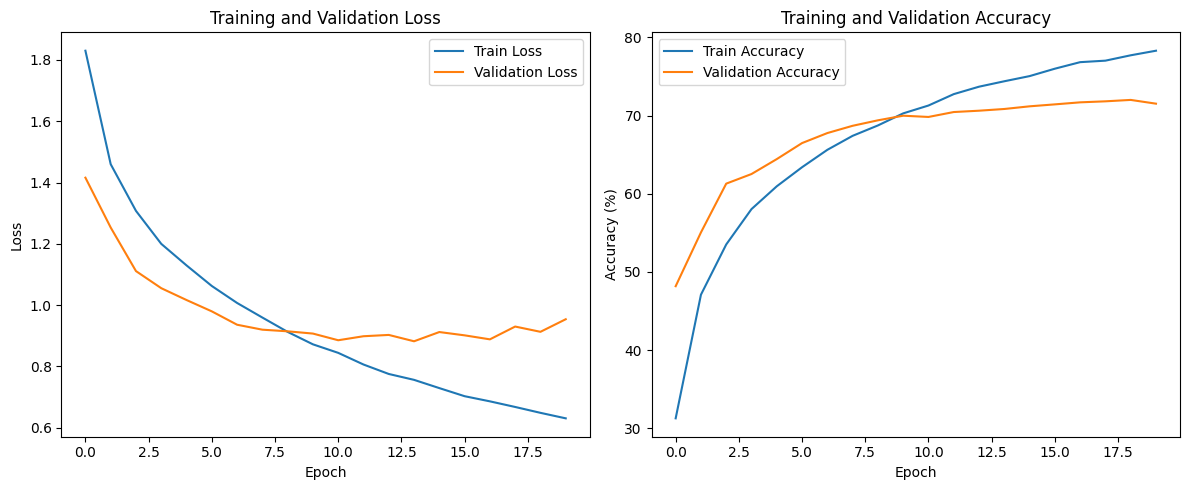


Training model: best_model
Epoch 1/20, Train Loss: 1.5204, Train Acc: 44.92%, Valid Loss: 1.2222, Valid Acc: 57.18%
Epoch 2/20, Train Loss: 1.1792, Train Acc: 57.98%, Valid Loss: 1.0275, Valid Acc: 63.28%
Epoch 3/20, Train Loss: 1.0214, Train Acc: 63.95%, Valid Loss: 0.9497, Valid Acc: 66.56%
Epoch 4/20, Train Loss: 0.9226, Train Acc: 67.23%, Valid Loss: 0.8910, Valid Acc: 68.69%
Epoch 5/20, Train Loss: 0.8522, Train Acc: 70.04%, Valid Loss: 0.8717, Valid Acc: 70.33%
Epoch 6/20, Train Loss: 0.7884, Train Acc: 72.31%, Valid Loss: 0.8241, Valid Acc: 71.36%
Epoch 7/20, Train Loss: 0.7324, Train Acc: 74.10%, Valid Loss: 0.8110, Valid Acc: 71.61%
Epoch 8/20, Train Loss: 0.6792, Train Acc: 75.71%, Valid Loss: 0.8215, Valid Acc: 72.24%
Epoch 9/20, Train Loss: 0.6351, Train Acc: 77.41%, Valid Loss: 0.8095, Valid Acc: 72.64%
Epoch 10/20, Train Loss: 0.5904, Train Acc: 78.89%, Valid Loss: 0.8355, Valid Acc: 71.96%
Epoch 11/20, Train Loss: 0.5520, Train Acc: 80.30%, Valid Loss: 0.8231, Valid Acc

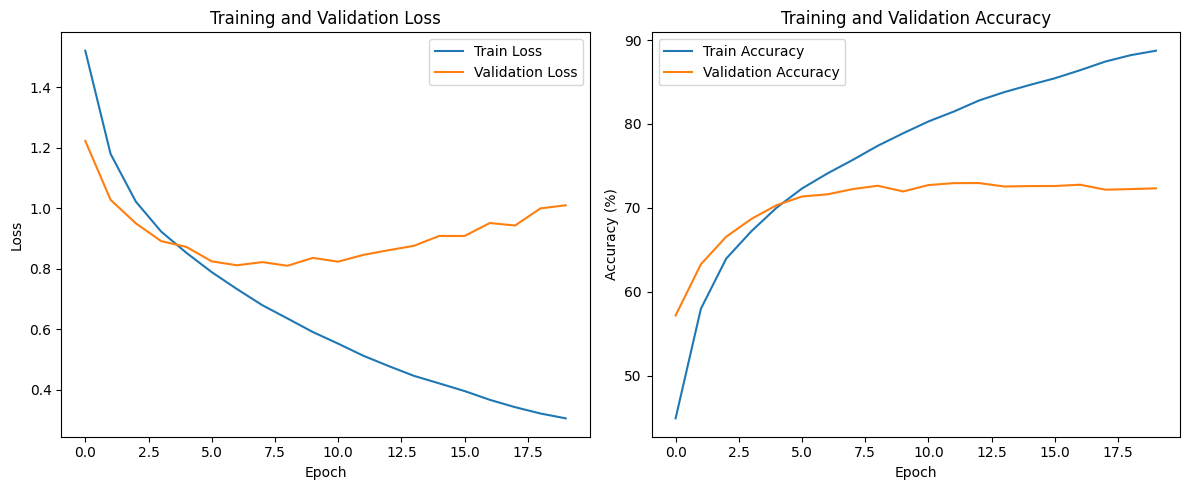

In [17]:
EPOCHS = 20

train_loader, valid_loader = get_cifar10()

hyperparams = {
    'avg_model': {'n_layers': 3, 'units': [84, 64, 26]},
    'best_model': {'n_layers': 1, 'units': [99]}
}

for model_name, params in hyperparams.items():
    print(f"\nTraining model: {model_name}")
    model = define_model_eval(params['n_layers'], params['units']).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = F.nll_loss

    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, train_loader, valid_loader, optimizer, criterion
    )

    plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)